In [1]:
# Package Imports
import pandas as pd
import numpy as np
from string import printable
from sklearn import model_selection
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Embedding, Convolution1D, ELU, MaxPooling1D, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Importing dataset
dataset = pd.read_csv('C:/Users/hp/OneDrive/Desktop/Malicious-Url-Detection-Updatedt (2)/data/malicious_phish.csv')


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
url     651191 non-null object
type    651191 non-null object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
missing_data = dataset.isnull().sum()
print(missing_data)

url     0
type    0
dtype: int64


In [5]:
dataset.head()

url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

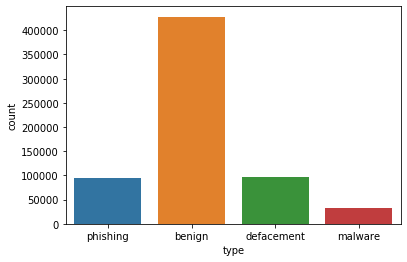

In [7]:
import seaborn as sns
sns.countplot(x="type", data = dataset)

In [8]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
dataset['type']= label_encoder.fit_transform(dataset['type'])
dataset['type'].unique()

array([3, 0, 1, 2], dtype=int64)

In [9]:
#dataset = dataset.drop_duplicates()

In [10]:
len(dataset)

651191

In [11]:
# List of printable characters
printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [12]:
# dataset preparation
# encode the printable characters in the url string as integers
def urlPrep(url):
    return [printable.index(char) + 1 for char in url if char in printable]

In [13]:
url_tokens = []
for url in dataset.url:
    url_tokens.append(urlPrep(url))

In [14]:
# Standardize the url string length in the dataset taking only the first 75 printable characters or padding with zeros
max_length = 75
url_data = sequence.pad_sequences(url_tokens, maxlen=max_length)

In [15]:
# target_label array
target_label = np.array(dataset.type)
target_label

array([3, 0, 0, ..., 3, 3, 3])

In [16]:
# Shape of the encoded url string array
url_data.shape

(651191, 75)

In [17]:
# Shape of the target labels array
target_label.shape

(651191,)

In [18]:
# splitting the url dataset using 20 percent for testing
url_train, url_test, target_train, target_test = model_selection.train_test_split(url_data, target_label, test_size=0.2)

In [19]:
def lstm_conv(max_len=75, emb_dim=32, max_vocab_len=1000, lstm_output_size=32, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len)(main_input) 
    emb = Dropout(0.25)(emb)

    # Conv layer
    conv = Convolution1D(kernel_size=5, filters=256)(emb)
    conv = ELU()(conv)

    conv = MaxPooling1D(pool_size=4)(conv)
    conv = Dropout(0.5)(conv)

    # LSTM layer
    lstm = LSTM(lstm_output_size)(conv)
    lstm = Dropout(0.5)(lstm)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(lstm)

    # Compile model and define optimizer
    model = Model(main_input, output)
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
epochs = 20
batch_size = 30

model = lstm_conv()
model.fit(url_train, target_train, epochs=epochs, batch_size=batch_size,steps_per_epoch=1000)

Epoch 1/20
1000/1000 [==============================] - 16s 16ms/step - loss: 0.1191 - accuracy: 0.3352
Epoch 2/20
1000/1000 [==============================] - 19s 19ms/step - loss: -1.4129 - accuracy: 0.6447
Epoch 3/20
1000/1000 [==============================] - 19s 19ms/step - loss: -2.0182 - accuracy: 0.6543
Epoch 4/20
1000/1000 [==============================] - 18s 18ms/step - loss: -2.5264 - accuracy: 0.6570
Epoch 5/20
1000/1000 [==============================] - 18s 18ms/step - loss: -3.0588 - accuracy: 0.6545
Epoch 6/20
1000/1000 [==============================] - 19s 19ms/step - loss: -3.6023 - accuracy: 0.6618 
Epoch 7/20
1000/1000 [==============================] - 19s 19ms/step - loss: -3.9595 - accuracy: 0.6742
Epoch 8/20
1000/1000 [==============================] - 19s 19ms/step - loss: -4.4586 - accuracy: 0.6583
Epoch 9/20
1000/1000 [==============================] - 19s 19ms/step - loss: -4.9944 - accuracy: 0.6534
Epoch 10/20
1000/1000 [==============================] 

In [21]:
loss, accuracy = model.evaluate(url_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')

4070/4070 [==============================] - 21s 5ms/step - loss: -11.6880 - accuracy: 0.6858

Final Cross-Validation Accuracy 0.6858237385749817 



In [22]:
model.save_weights('model_convolutional.h5')

In [23]:
model.load_weights('model_convolutional.h5')

In [24]:
test_url_mal = "naureen.net/etisalat.ae/index2.php"
test_url_benign = "sixt.com/php/reservation?language=en_US"

url = "www.google.co.in/sfdghgm"

In [25]:
url_int_tokens = [[printable.index(x) + 1 for x in test_url_benign if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)

In [26]:
target_proba = model.predict(X, batch_size=1)
def print_result(proba):
    if proba > 0.5:
        return "malicious"
    else:
        return "benign"
print("Test URL:", url, "is", print_result(target_proba[0]))

Test URL: www.google.co.in/sfdghgm is benign


# Machine Learning

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
ds= pd.read_csv("data/dataset_website.csv")
ds.head()

Index  UsingIP  LongURL  ShortURL  Symbol@  Redirecting//  PrefixSuffix-  \
0      0        1        1         1        1              1             -1   
1      1        1        0         1        1              1             -1   
2      2        1        0         1        1              1             -1   
3      3        1        0        -1        1              1             -1   
4      4       -1        0        -1        1             -1             -1   

   SubDomains  HTTPS  DomainRegLen  ...  UsingPopupWindow  IframeRedirection  \
0           0      1            -1  ...                 1                  1   
1          -1     -1            -1  ...                 1                  1   
2          -1     -1             1  ...                 1                  1   
3           1      1            -1  ...                -1                  1   
4           1      1            -1  ...                 1                  1   

   AgeofDomain  DNSRecording  WebsiteTraffic  PageRank  GoogleIndex  \
0           -1            -1               0        -1            1   
1            1            -1               1        -1            1   
2           -1            -1               1        -1            1   
3           -1            -1               0        -1            1   
4            1             1               1        -1            1   

   LinksPointingToPage  StatsReport  class  
0                    1            1     -1  
1                    0           -1     -1  
2                   -1            1     -1  
3                    1            1      1  
4                   -1           -1      1  

[5 rows x 32 columns]

In [29]:
ds.isnull().any() #no nullvalues

Index                  False
UsingIP                False
LongURL                False
ShortURL               False
Symbol@                False
Redirecting//          False
PrefixSuffix-          False
SubDomains             False
HTTPS                  False
DomainRegLen           False
Favicon                False
NonStdPort             False
HTTPSDomainURL         False
RequestURL             False
AnchorURL              False
LinksInScriptTags      False
ServerFormHandler      False
InfoEmail              False
AbnormalURL            False
WebsiteForwarding      False
StatusBarCust          False
DisableRightClick      False
UsingPopupWindow       False
IframeRedirection      False
AgeofDomain            False
DNSRecording           False
WebsiteTraffic         False
PageRank               False
GoogleIndex            False
LinksPointingToPage    False
StatsReport            False
class                  False
dtype: bool

In [30]:
ds.isnull().any()   #no missing data in the dataset

Index                  False
UsingIP                False
LongURL                False
ShortURL               False
Symbol@                False
Redirecting//          False
PrefixSuffix-          False
SubDomains             False
HTTPS                  False
DomainRegLen           False
Favicon                False
NonStdPort             False
HTTPSDomainURL         False
RequestURL             False
AnchorURL              False
LinksInScriptTags      False
ServerFormHandler      False
InfoEmail              False
AbnormalURL            False
WebsiteForwarding      False
StatusBarCust          False
DisableRightClick      False
UsingPopupWindow       False
IframeRedirection      False
AgeofDomain            False
DNSRecording           False
WebsiteTraffic         False
PageRank               False
GoogleIndex            False
LinksPointingToPage    False
StatsReport            False
class                  False
dtype: bool

In [31]:
x=ds.iloc[:,1:31].values
y=ds.iloc[:,-1].values
print(x,y)

[[ 1  1  1 ...  1  1  1]
 [ 1  0  1 ...  1  0 -1]
 [ 1  0  1 ...  1 -1  1]
 ...
 [ 1 -1  1 ...  1  0  1]
 [-1 -1  1 ...  1  1  1]
 [-1 -1  1 ... -1  1 -1]] [-1 -1 -1 ... -1 -1 -1]


In [32]:
y=ds.iloc[:,-1].values
y

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [33]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

# LOGISTIC REGRESSION

In [43]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
y_pred1=lr.predict(x_test)
from sklearn.metrics import accuracy_score
log_reg=accuracy_score(y_test,y_pred1)
log_reg

0.926729986431479

# KNeighborsClassifier Using Cosine Metric

In [34]:
from sklearn.neighbors import KNeighborsClassifier
kn1=KNeighborsClassifier(n_neighbors=5,metric='cosine')  
kn1.fit(x_train,y_train)
y_pred2=kn1.predict(x_test)
from sklearn.metrics import accuracy_score
knn_cos=accuracy_score(y_test,y_pred2)
knn_cos

0.9511533242876526

# SVM

In [35]:
from sklearn.svm import SVC
svm1=SVC(kernel='rbf', gamma='auto')
svm1.fit(x_train,y_train) 
y_pred4=svm1.predict(x_test)
from sklearn.metrics import accuracy_score
svm_rbf=accuracy_score(y_test,y_pred4)
svm_rbf

0.9470827679782904

# DECISION TREE

In [36]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred6=dt.predict(x_test)
from sklearn.metrics import accuracy_score
dec_tree=accuracy_score(y_test,y_pred6)
dec_tree

0.9606512890094979

# RANDOM FOREST

In [37]:
from sklearn.ensemble import RandomForestRegressor
Rf=RandomForestRegressor(n_estimators=100,random_state=0,n_jobs=-1)     
Rf.fit(x_train,y_train)
y_pred7=Rf.predict(x_test)
from sklearn.metrics import accuracy_score
rf=accuracy_score(y_test,y_pred7.round())
rf

0.942107643600181

# GaussianNB

In [38]:
from sklearn.naive_bayes import GaussianNB
gb=GaussianNB()
gb.fit(x_train,y_train)
y_pred8=gb.predict(x_test)
from sklearn.metrics import accuracy_score
nb=accuracy_score(y_test,y_pred8)
nb

0.5911352329262777

In [47]:
models = pd.DataFrame({
    'Model': [ 'Logistic Regression', 'KNN','Naive Bayes','SVM','Decision Tree','Random Forest'],
    'Test Score': [ log_reg,knn_cos,nb,svm_rbf,dec_tree,rf]})
models.sort_values(by='Test Score', ascending=False)

Model  Test Score
4        Decision Tree    0.960651
1                  KNN    0.951153
3                  SVM    0.947083
5        Random Forest    0.942108
0  Logistic Regression    0.926730
2          Naive Bayes    0.591135

In [49]:
import pickle
pickle.dump(dt,open('Phising_website.pkl','wb'))